In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from pathlib import Path
from src.target import TargetEncoder
from src.woe import WeigthOfEvidenceEncoder

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import StratifiedKFold, cross_validate, RandomizedSearchCV, train_test_split
from sklearn.metrics import classification_report
from sklearn.compose import make_column_selector as selector
from sklearn import set_config

from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.inspection import partial_dependence, plot_partial_dependence

In [4]:
set_config(display='diagram')

In [5]:
plt.style.use('ggplot')
%load_ext autoreload
%autoreload 2

In [6]:
path = Path('..', 'data', 'raw')
credit = pd.read_csv(path / 'credit_data.csv').rename(columns=str.lower)

In [5]:
dep_var = 'status'
cat_names = ['home', 'marital', 'records', 'job']
cnt_names = ['seniority', 'time', 'age', 'expenses', 'income', 'debt', 'amount', 'price', 'assets']

In [6]:
credit[cat_names] = credit[cat_names].astype('category')

In [7]:
n = len(credit)
valid_idx = np.random.choice(range(n), np.ceil(n * 0.2).astype('int'))
train_idx = [i for i in range(n) if i not in valid_idx]

In [8]:
X_train, y_train = credit.loc[train_idx, credit.columns != 'status'], credit.loc[train_idx, 'status']
X_test, y_test = credit.loc[valid_idx, credit.columns != 'status'], credit.loc[valid_idx, 'status']

In [9]:
ohe_transf = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder())
])

target_transf = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('target', TargetEncoder(cols=['home', 'marital', 'records', 'job']))
])

woe_transf = Pipeline([
    ('impute', SimpleImputer(strategy='most_frequent')),
    ('woe', WeigthOfEvidenceEncoder(cols=['home', 'marital', 'records', 'job']))
])

cnt_transf = Pipeline([
    ('impute', SimpleImputer(strategy='mean'))
])

col_transform = ColumnTransformer([
    ('categorical', woe_transf, selector(dtype_include=object)),
    ('continuos', cnt_transf, selector(dtype_include=np.number))
])

In [2]:
credit.columns

NameError: name 'credit' is not defined

In [14]:
encodings = {
    'ohe': ohe_transf, 
    'likelihood': target_transf,
    'woe': woe_transf
}

In [8]:
credit.columns

Index(['status', 'seniority', 'home', 'time', 'age', 'marital', 'records',
       'job', 'expenses', 'income', 'assets', 'debt', 'amount', 'price'],
      dtype='object')

In [10]:
clf = Pipeline([
    ('preproc', col_transform),
    ('model', RandomForestClassifier(n_estimators=200))
])

In [12]:
scoring = ['precision_macro', 'recall_macro', 'accuracy']
cv = StratifiedKFold(n_splits=10)
scores = cross_validate(clf, X_train, y_train, cv=cv, scoring=scoring, n_jobs=3)

In [13]:
clf = clf.fit(X_train, y_train)
pred = clf.predict(X_test)

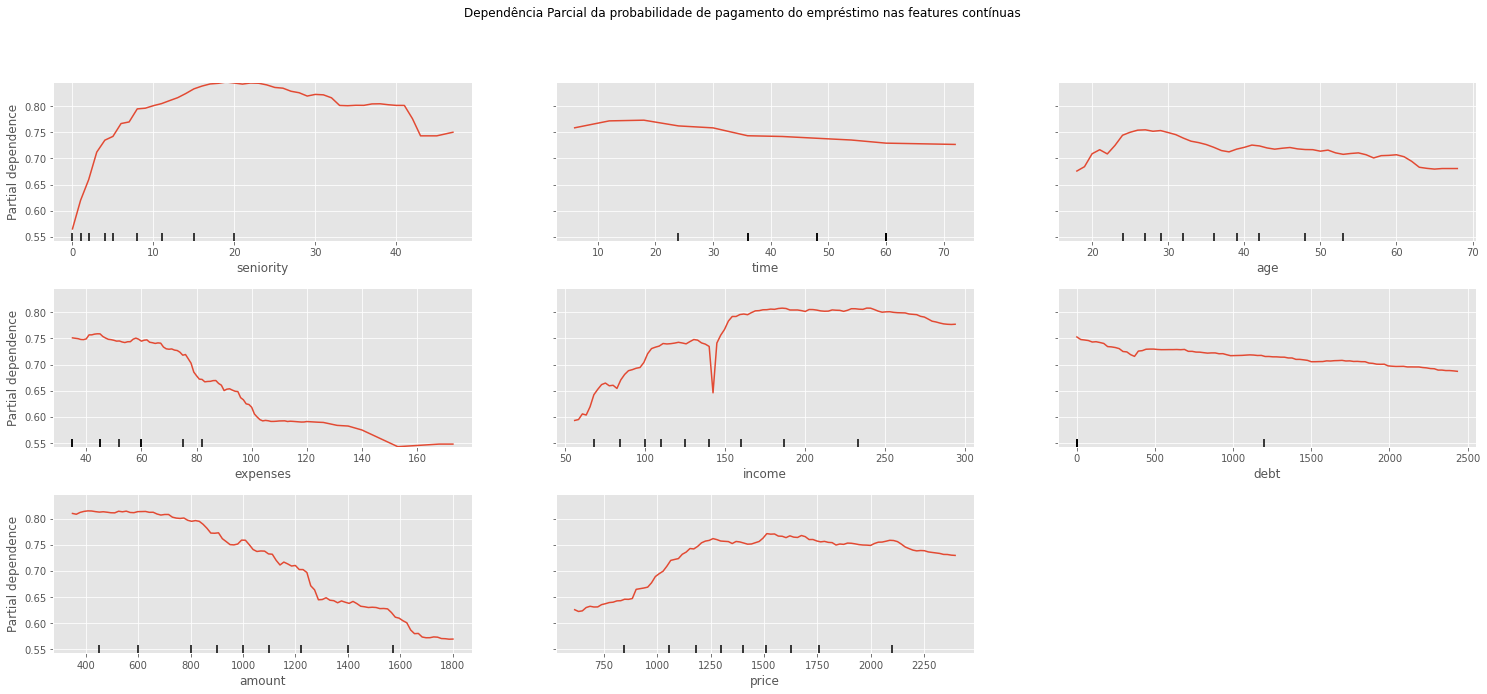

In [108]:
plot_partial_dependence(clf, X_train.dropna(), cnt_names, n_jobs=3, grid_resolution=100)
fig = plt.gcf()
fig.set_size_inches(25.5, 10.5)
fig.suptitle('Dependência Parcial da probabilidade de pagamento do empréstimo nas features contínuas')
fig.subplots_adjust(hspace=0.3)
plt.savefig('../reports/figures/partial_dependence.png')

In [71]:
print(classification_report(pred, y_test))

precision    recall  f1-score   support

         bad       0.39      0.68      0.49       156
        good       0.92      0.77      0.84       735

    accuracy                           0.76       891
   macro avg       0.65      0.73      0.67       891
weighted avg       0.83      0.76      0.78       891



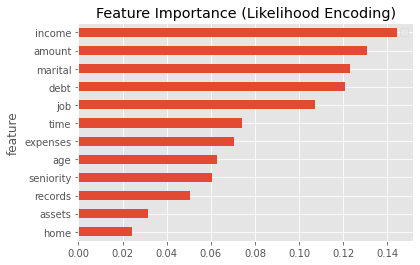

In [98]:
feat_imp = zip(X_train.columns, rnd_for._final_estimator.feature_importances_)
feat_imp = (pd.DataFrame(feat_imp, columns=['feature', 'imp'])
    .set_index('feature')
    .sort_values('imp'))
feat_imp.plot(kind='barh', title='Feature Importance (Likelihood Encoding)')
plt.legend('');

In [101]:
# Opçãa passar indices 
target_pipe.fit_transform(X_train.select_dtypes('category'), y_train)

,home,marital,records,job
0,-0.431442,-1.075302,-1.252122,-0.702167
1,-0.431442,-1.049875,-1.252122,-1.340723
2,-1.465396,-1.075302,0.237329,-0.702167
3,-0.431442,-0.651238,-1.252122,-1.340723
4,-1.465396,-1.075302,-1.252122,-1.340723
...,...,...,...,...
3639,-1.465396,-1.075302,-1.252122,-1.340723
3640,-0.195761,-1.075302,0.237329,0.371794
3641,-1.465396,-1.075302,-1.252122,-1.340723
3642,-1.465396,-1.075302,-1.252122,0.371794


In [80]:
target_pipe.fit_transform(X_train, y_train)

AssertionError: Number of manager items must equal union of block items
# manager items: 4, # tot_items: 13

In [58]:
imp=SimpleImputer(strategy='most_frequent')
pd.DataFrame(imp.fit_transform(X_train.select_dtypes('category')), columns=cat_names)

,home,marital,records,job
0,rent,married,no,freelance
1,rent,widow,no,fixed
2,owner,married,yes,freelance
3,rent,single,no,fixed
4,owner,married,no,fixed
...,...,...,...,...
3639,owner,married,no,fixed
3640,other,married,yes,partime
3641,owner,married,no,fixed
3642,owner,married,no,partime
